In [17]:
# ==========================================================
# 0) Install & Import
# ==========================================================
!pip -q install yfinance pandas numpy scikit-learn matplotlib tensorflow==2.* joblib

import os, math, warnings, random
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, callbacks, Sequential
from tensorflow.keras.models import Model

plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["axes.grid"] = True

[*********************100%***********************]  1 of 1 completed


=== INFORMASI DATASET UNIVARIATE ===
Range data: 2020-04-10 -> 2025-12-21
Total entri data: 2082
Window: 48, Horizon: 1

=== STRUKTUR DATASET (df.info()) ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2082 entries, 2020-04-10 to 2025-12-21
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, SOL-USD)  2082 non-null   float64
dtypes: float64(1)
memory usage: 32.5 KB

=== STATISTIK DESKRIPTIF DATASET ===
Price         Close
Ticker      SOL-USD
count   2082.000000
mean      86.066460
std       74.357413
min        0.515273
25%       20.552560
50%       55.487791
75%      149.394081
max      261.869751

=== 5 DATA TERBARU ===
Price            Close
Ticker         SOL-USD
Date                  
2025-12-17  123.119804
2025-12-18  119.570152
2025-12-19  126.192749
2025-12-20  125.809036
2025-12-21  126.334908


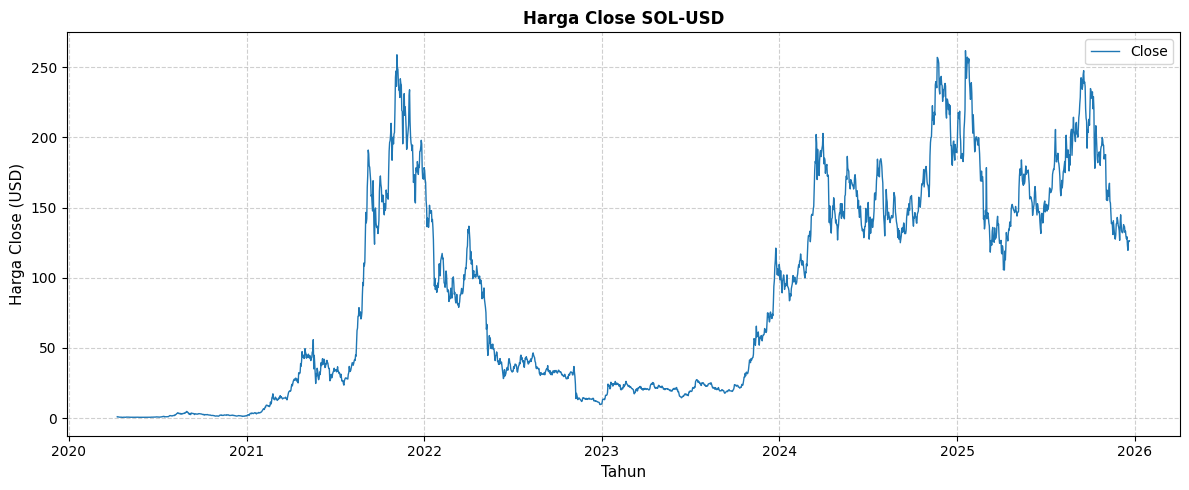

In [18]:
# ==========================================================
# 1) Load Dataset (Yahoo Finance) - UNIVARIATE (Close-only)
# ==========================================================
import yfinance as yf
import matplotlib.pyplot as plt

TICKER = "SOL-USD"
START_DATE = "2020-04-10"
INTERVAL = "1d"
WINDOW = 48
HORIZON = 1

# --- Download dataset ---
df = yf.download(TICKER, start=START_DATE, interval=INTERVAL)

# --- Ambil hanya fitur Close ---
df = df[["Close"]].astype(float).dropna()
N_FEATURES = 1  # Hanya 1 fitur

# ==========================================================
# Informasi Dataset
# ==========================================================
print("=== INFORMASI DATASET UNIVARIATE ===")
print("Range data:", df.index.min().date(), "->", df.index.max().date())
print("Total entri data:", len(df))
print(f"Window: {WINDOW}, Horizon: {HORIZON}")

# --- Struktur dataset ---
print("\n=== STRUKTUR DATASET (df.info()) ===")
df.info()

# --- Statistik deskriptif ---
print("\n=== STATISTIK DESKRIPTIF DATASET ===")
print(df.describe())

# --- Tampilkan 5 data terakhir ---
print("\n=== 5 DATA TERBARU ===")
print(df.tail())

# ==========================================================
# Visualisasi Harga Close
# ==========================================================
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Close"], linewidth=1, label="Close")
plt.title(f"Harga Close {TICKER}", fontsize=12, fontweight="bold")
plt.xlabel("Tahun", fontsize=11)
plt.ylabel("Harga Close (USD)", fontsize=11)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [19]:
# ==========================================================
# 2) Preprocessing + Sliding Window
# ==========================================================
from sklearn.preprocessing import MinMaxScaler
import numpy as np

TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

def make_xy(arr_scaled, window=WINDOW, horizon=HORIZON):
    X, y = [], []
    n = len(arr_scaled)
    for i in range(n - window - horizon + 1):
        X.append(arr_scaled[i:i+window])           # (window, 1)
        y.append(arr_scaled[i+window+horizon-1])   # (1,)
    return np.array(X), np.array(y)

# Split raw series (sebelum scaling)
N = len(df)
n_train = int(N * TRAIN_RATIO)
n_val   = int(N * VAL_RATIO)

df_train = df.iloc[:n_train]
df_val   = df.iloc[n_train:n_train+n_val]
df_test  = df.iloc[n_train+n_val:]

# Fit scaler di TRAIN
scaler = MinMaxScaler((0, 1))
scaler.fit(df_train[["Close"]])

train_scaled = scaler.transform(df_train[["Close"]])
val_scaled   = scaler.transform(df_val[["Close"]])
test_scaled  = scaler.transform(df_test[["Close"]])

# Window per subset (tidak menyeberang batas)
X_train, y_train = make_xy(train_scaled, WINDOW, HORIZON)
X_val,   y_val   = make_xy(val_scaled,   WINDOW, HORIZON)
X_test,  y_test  = make_xy(test_scaled,  WINDOW, HORIZON)

# Index tanggal untuk plotting (offset WINDOW saat plot)
df_train_idx = df_train.index
df_val_idx   = df_val.index
df_test_idx  = df_test.index

# Helper inverse + full scaled utk forecast ke depan
def inverse_close(y_scaled_1d):
    y_scaled_1d = np.array(y_scaled_1d).reshape(-1,1)
    return scaler.inverse_transform(y_scaled_1d).ravel()

# scaled full series (pakai scaler TRAIN) untuk prediksi besok/30D
close_scaled = scaler.transform(df[["Close"]])


X_all, y_all = make_xy(close_scaled, WINDOW, HORIZON)
print("\nShape keseluruhan:", X_all.shape, y_all.shape)

print(f"Split manual → Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Rasio: Train={TRAIN_RATIO*100:.0f}%, Val={VAL_RATIO*100:.0f}%, Test={TEST_RATIO*100:.0f}%")


Shape keseluruhan: (2034, 48, 1) (2034, 1)
Split manual → Train: (1409, 48, 1), Val: (264, 48, 1), Test: (265, 48, 1)
Rasio: Train=70%, Val=15%, Test=15%


In [20]:
# ==========================================================
# 3) Build PURE Bi-LSTM (Univariate Input)
# ==========================================================
def build_pure_bilstm_univariate(window=WINDOW, n_features=N_FEATURES, lr=1e-3):
    # Input shape adalah (WINDOW, 1)
    model = Sequential([
        layers.Input(shape=(window, n_features)),
        layers.Bidirectional(layers.LSTM(150, return_sequences=True), name="bilstm_1"),
        layers.Dropout(0.2, name="drop_1"),
        layers.Bidirectional(layers.LSTM(50, return_sequences=False), name="bilstm_2"),
        layers.Dense(64, activation="relu", name="dense_64"),
        layers.Dense(32, activation="relu", name="dense_32"),
        layers.Dense(1, activation="linear", name="out")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"]
    )
    return model

# Panggil model
model = build_pure_bilstm_univariate(WINDOW, N_FEATURES, lr=1e-3)
print("\n=== PURE BI-LSTM UNIVARIATE MODEL SUMMARY ===")
model.summary()


=== PURE BI-LSTM UNIVARIATE MODEL SUMMARY ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bilstm_1 (Bidirectional)        │ (None, 48, 300)        │       182,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_1 (Dropout)                │ (None, 48, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_2 (Bidirectional)        │ (None, 100)            │       140,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,377 (1.26 MB)

 Trainable params: 331,377 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - loss: 0.0100 - mae: 0.0482 - val_loss: 0.0502 - val_mae: 0.2022 - learning_rate: 0.0010
Epoch 2/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0521 - mae: 0.1489 - val_loss: 0.0102 - val_mae: 0.0888 - learning_rate: 0.0010
Epoch 3/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0058 - mae: 0.0606 - val_loss: 0.0062 - val_mae: 0.0579 - learning_rate: 0.0010
Epoch 4/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028 - mae: 0.0405 - val_loss: 0.0058 - val_mae: 0.0576 - learning_rate: 0.0010
Epoch 5/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016 - mae: 0.0260 - val_loss: 0.0054 - val_mae: 0.0560 - learning_rate: 0.0010
Epoch 6/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - mae: 0.0254 - val_loss: 0.0057 - val_mae: 0.0559 - learning_rate: 0.0010
Epoch 7/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - mae: 0.0238 - val_loss: 0.0055 - val_mae: 0.0554 - learning_rate: 0.0010
Epoch

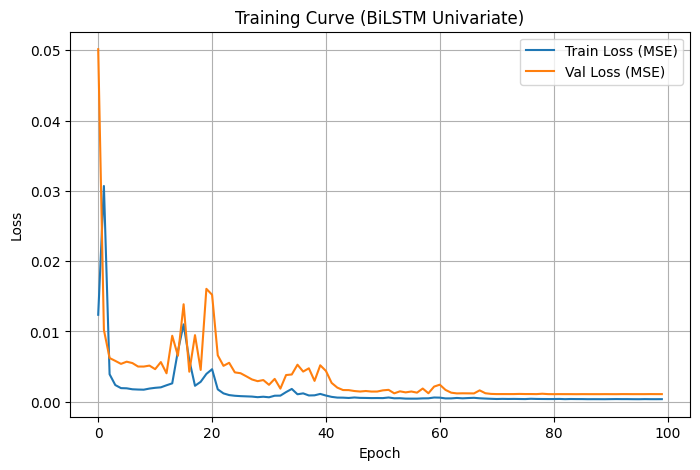

In [21]:
# ==========================================================
# 4) Callbacks
# ==========================================================
es = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-6, verbose=1)

# ==========================================================
# 5) Training
# ==========================================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=16,
    shuffle=False,
    callbacks=[es, rlr],
    verbose=1
)

# ==========================================================
# 6) Visualisasi Loss
# ==========================================================
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.title("Training Curve (BiLSTM Univariate)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()


=== TRAINING EVALUATION ===
RMSE   : 4.8317 USD
RMSE % : 9.24%
MAPE   : 11.64%


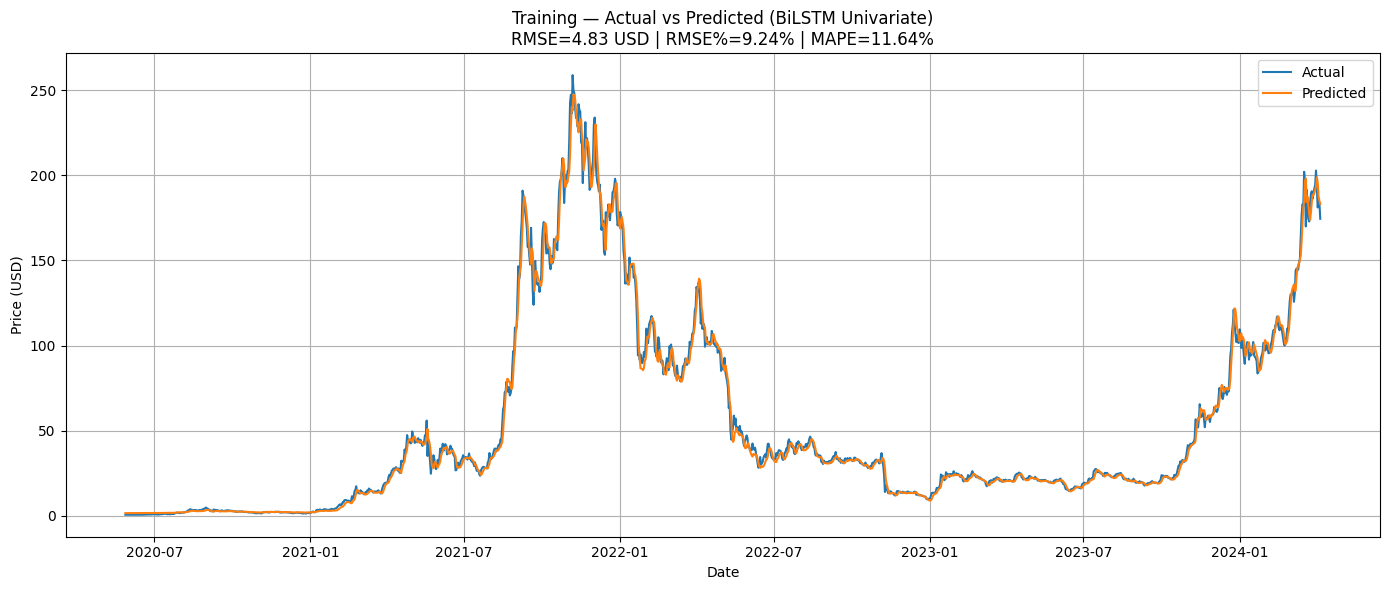


=== VALIDATION EVALUATION ===
RMSE   : 8.4862 USD
RMSE % : 4.82%
MAPE   : 3.69%


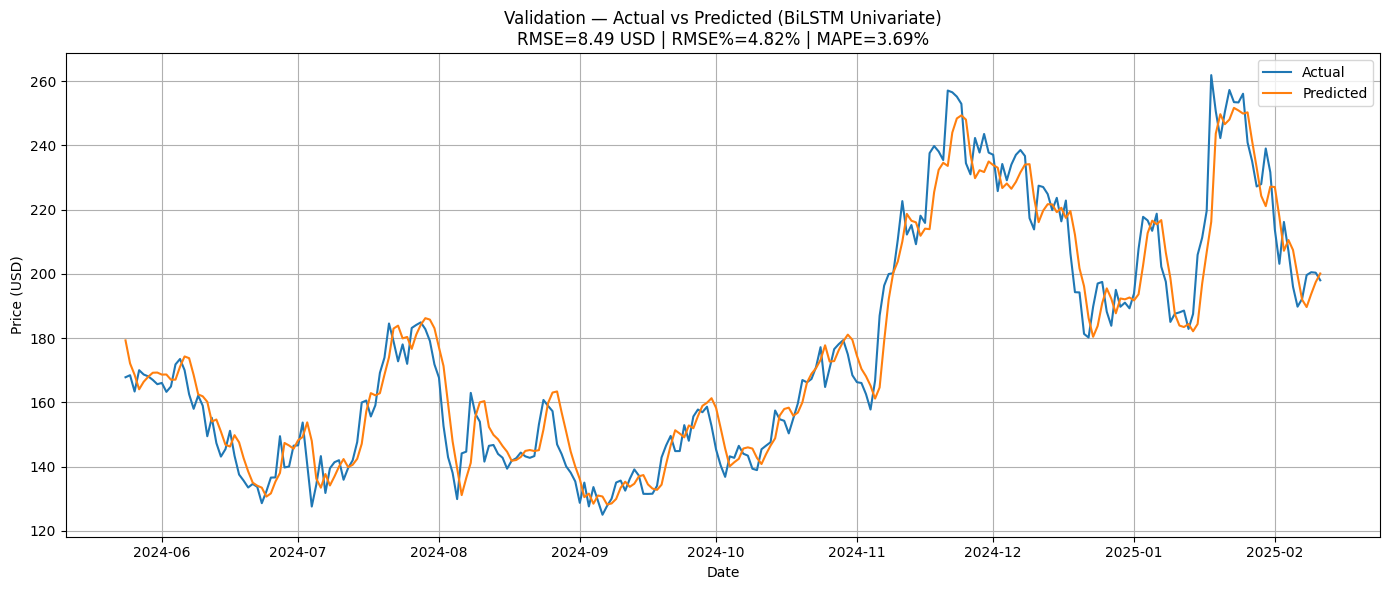


=== TEST EVALUATION ===
RMSE   : 7.6441 USD
RMSE % : 4.54%
MAPE   : 3.55%


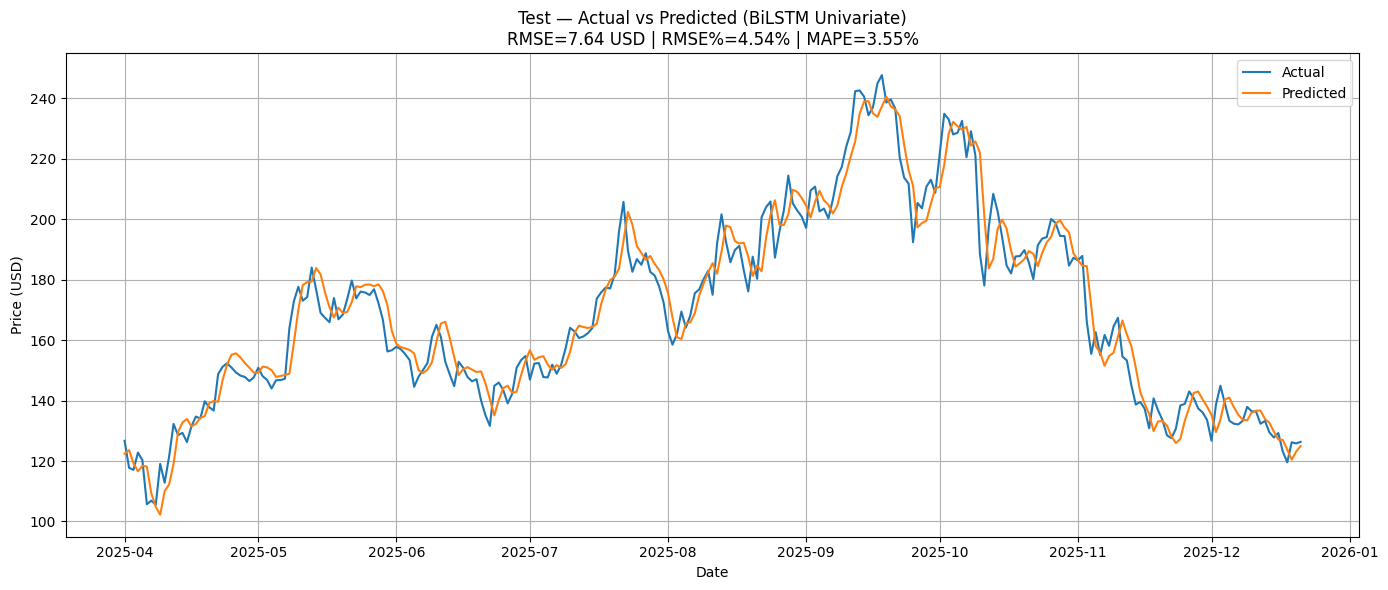

In [22]:
# ==========================================================
# 7) Evaluasi (RMSE, RMSE%, MAPE) + Plot Train/Val/Test
# ==========================================================
def inverse_close(y_scaled):
    """Inverse MinMax untuk vektor 1D."""
    return scaler.inverse_transform(np.array(y_scaled).reshape(-1,1)).ravel()

def evaluate_and_plot(name, model, X, y, date_start_index):
    """
    date_start_index: index tanggal untuk set terkait (raw df),
      plotting dimulai dari offset WINDOW agar alignment tepat.
    """
    y_pred_scaled = model.predict(X, verbose=0).ravel()
    y_true = inverse_close(y.ravel())
    y_pred = inverse_close(y_pred_scaled)

    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mean_true = np.mean(y_true)
    rmse_pct = (rmse / (mean_true if abs(mean_true) > 1e-12 else 1e-12)) * 100.0
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100.0

    print(f"\n=== {name.upper()} EVALUATION ===")
    print(f"RMSE   : {rmse:.4f} USD")
    print(f"RMSE % : {rmse_pct:.2f}%")
    print(f"MAPE   : {mape:.2f}%")

    # Buat index tanggal sejajar dengan y (WINDOW offset)
    if len(date_start_index) >= WINDOW:
        date_idx = date_start_index[WINDOW:]
    else:
        date_idx = pd.RangeIndex(start=0, stop=len(y_true))

    plt.figure(figsize=(14,6))
    plt.plot(date_idx, y_true, label="Actual")
    plt.plot(date_idx, y_pred, label="Predicted")
    plt.title(
        f"{name} — Actual vs Predicted (BiLSTM Univariate)\n"
        f"RMSE={rmse:.2f} USD | RMSE%={rmse_pct:.2f}% | MAPE={mape:.2f}%"
    )
    plt.xlabel("Date"); plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rmse, rmse_pct, mape, y_true, y_pred


# ==========================================================
# 7.b) Evaluasi & Plot Train/Val/Test dengan RMSE%
# ==========================================================
rmse_train, rmse_pct_train, mape_train, y_train_true, y_train_pred = evaluate_and_plot(
    "Training", model, X_train, y_train, df_train_idx
)
rmse_val, rmse_pct_val, mape_val, y_val_true, y_val_pred = evaluate_and_plot(
    "Validation", model, X_val, y_val, df_val_idx
)
rmse_test, rmse_pct_test, mape_test, y_test_true, y_test_pred = evaluate_and_plot(
    "Test", model, X_test, y_test, df_test_idx
)


In [23]:
# ==========================================================
# 8) Simpan Model & Scaler
# ==========================================================
os.makedirs("artifacts", exist_ok=True)
MODEL_PATH = "artifacts/bilstm_univariate.keras"
SCALER_PATH = "artifacts/scaler.pkl"

model.save(MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
print(f"\n[SAVED] Model: {MODEL_PATH}")
print(f"[SAVED] Scaler: {SCALER_PATH}")


[SAVED] Model: artifacts/bilstm_univariate.keras
[SAVED] Scaler: artifacts/scaler.pkl



Last Close     : 126.33 USD
Prediksi besok : 126.30 USD
Prediksi 30 hari (10 teratas): [126.3  126.86 127.4  127.71 128.08 128.43 129.01 129.78 130.54 131.46] ...


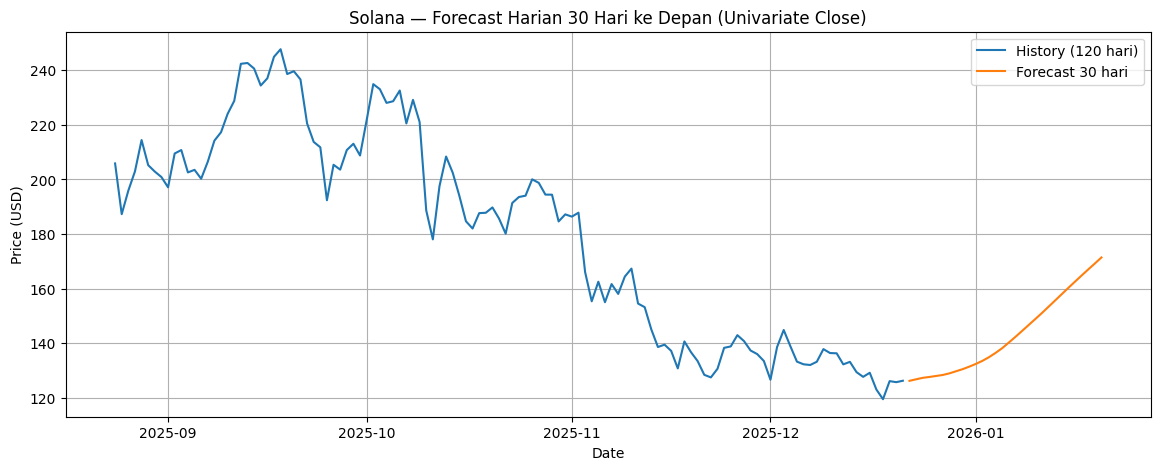

In [24]:
# ==========================================================
# 9) Prediksi Real-time (besok) & Forecast 30 hari (recursive)
# ==========================================================
def predict_next_close(model, series_scaled, window=WINDOW):
    """
    series_scaled: array shape (n, 1) keseluruhan close_scaled
    """
    x = series_scaled[-window:]             # (window, 1)
    x = np.expand_dims(x, axis=0)           # (1, window, 1)
    y_hat_scaled = model.predict(x, verbose=0).ravel()[0]
    return inverse_close([y_hat_scaled])[0]

def forecast_30d(model, series_scaled, steps=30, window=WINDOW):
    """
    Recursive forecast: tiap langkah hanya memperbarui target (Close) scaled.
    """
    buf = series_scaled.copy()              # shape (n,1)
    preds_scaled = []
    for _ in range(steps):
        x = np.expand_dims(buf[-window:], axis=0)
        y_hat_scaled = model.predict(x, verbose=0).ravel()[0]
        preds_scaled.append(y_hat_scaled)
        buf = np.vstack([buf, [[y_hat_scaled]]])  # append 1 langkah (univariate)
    return inverse_close(preds_scaled)

last_close = float(df["Close"].iloc[-1])
next_close_pred = predict_next_close(model, close_scaled, WINDOW)
pred30 = forecast_30d(model, close_scaled, steps=30, window=WINDOW)

print(f"\nLast Close     : {last_close:.2f} USD")
print(f"Prediksi besok : {next_close_pred:.2f} USD")
print("Prediksi 30 hari (10 teratas):", np.round(pred30[:10], 2), "...")

# Index tanggal untuk 30D ke depan
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq="D")

# Plot Forecast 30D
plt.figure(figsize=(14,5))
plt.plot(df.index[-120:], df["Close"].iloc[-120:], label="History (120 hari)")
plt.plot(future_index, pred30, label="Forecast 30 hari")
plt.title("Solana — Forecast Harian 30 Hari ke Depan (Univariate Close)")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.grid(True); plt.show()